<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-2-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Deep Learning for Option Pricing

## Introduction

The problem of this first part of our lessons can be stated simply as follow. Let's say, from a very general point of view, that we have a contingent claim $\cal{V}$ that depends on $D$ parameters:

$$
\cal{V}(\mathbf{x}), \, \mathbf{x}=\left\{x_1,\dots, x_D \right\} \in \mathbb{R}^D
$$

We want to **approximate the pricing function with a neural network**. Remember that we can always consider the NN as a sort of mapping function 

$$
\Phi : \mathbb{R}^D \rightarrow \mathbb{R}
$$

trained to compute prices given a point in $\mathbb{R}^D$ representing a particular set of parameters. 

The use of a NN as a pricing functions has a number of advantages. the first is that in this way we are able to compute efficiently thousands of prices in a small amount of time, even when the derivative contract has complicated conditions and when the model is complex. This comes with the downside that the neural network may introduce systematic errors that could affect our estimation of the sensitivities in a number of ways. 

The second advantage is that instead of training the network on the model parameters, which in general are not observable, we could train the network ***using data that is directly observable in the market***. For example quotes and trades by market participants provide points on the
volatility surface. Interpolating between these points as necessary, a trader can derive a reasonable
estimate of the implied volatility appropriate for any new plain vanilla European or American
option that is of interest. Plain vanilla options are therefore not priced using a model. They are
simply priced to be consistent with the market. 

The volatility surface derived from the Black–Scholes–Merton model is a convenient interpolation tool for doing this.

Exotic options are generally not as actively traded as plain vanilla options and, as a result, a
model is required for pricing. A variety of different models are used in practice. Two conditions
that traders would like the model to satisfy are:

- A. The stochastic behavior assumed for the underlying asset price should correspond reasonably well to its observed behavior, and

- B. The volatility surface derived from the model should be reasonably consistent with the volatility surface used to price plain vanilla options.

Two categories of models that are used in practice can be distinguished. The models in the first
category focus on condition A by assuming a process for the asset price that is roughly consistent
with its observed behavior. The models have parameters that can be chosen to provide an
approximate fit to the current volatility surface. Models in the second category focus on condition B
and are designed to be exactly consistent with the current volatility surface. Many different models in the first category involving stochastic volatility and jumps have been
proposed. Examples of stochastic volatility models are Hull and White (1987) and Heston (1993).
Merton (1976) proposed a model that overlays Black-Scholes-Merton model with jumps. Bates
(1996) adds jumps to Heston (1993). Madan et al (1998) propose a variance–gamma model where
there are only jumps. More recently, rough volatility models where the process for volatility is
non-Markov have been suggested by authors such as Gatheral et al (2018).

The second category of models are referred to as local volatility models. The original onefactor
local volatility model was suggested by Dupire (1994) and Derman and Kani (1994). It has been extended by authors such as Ren et al (2007) and Saporito et al (2019). Local volatility
models by design satisfy condition B.

The usual approach to implementing models in the first category is to choose model
parameters to fit the volatility surface as closely as possible. This approach, which we refer to as
the ***“model calibration approach”*** or ***MCA***. A drawback of the approach is that some of the points on the volatility
surface are likely to be more important than others for any particular exotic option that is
considered. It is of course possible to vary the weights assigned to different points on the volatility
surface according to the instrument being valued. However, it is difficult to determine in advance
what these weights should be. As a result, the points are usually given equal weight when model
parameters are determined.

Neural networks can be used in
conjunction with MCA to provide fast pricing once model parameters have been determined.
Consider an exotic option that is valued using Monte Carlo simulation. As a first step, it is necessary
to devote computational resources to creating a data set relating model parameters and exotic
option parameters to the price. The pricing model can then be replicated with a neural network.
Once this has been done, valuation is several orders of magnitude faster than Monte Carlo
simulation because it involves nothing more than a forward pass through the neural network.

In this first notebook we will look at a simple example of this approach. For the sake of simplicity we will consider an example based on the Black and Scholes model for the pricing of a simple European option.

In the second part of these lessons we'll see how to train a neural network on market data (volatility surface) using the heston model as the underlying model.

**Specifically, in this notebook:**

- We generate a large **synthetic dataset** of option parameters (maturity, strike-to-spot ratio, and volatility) using **Latin Hypercube Sampling (LHS)**, to cover the typical range of market conditions.
- We compute exact Black-Scholes option prices for this synthetic data, building a training set that approximates the theoretical pricing function.
- We construct and train a **fully connected feed-forward neural network** (three hidden layers, ReLU activation) to approximate the mapping from option features to prices.
- We evaluate the performance of the network using Mean Absolute Error (MAE) and Mean Squared Error (MSE) metrics, ensuring consistency with the training objectives discussed in the lectures.
- We save the trained model for later use in fast, real-time pricing applications.

This exercise serves as the first, simpler example before extending the approach to more complex models (e.g., Heston stochastic volatility) and full VFA using implied volatility smiles, as discussed in later parts of the course.

## The Black and Scholes Model

We consider an underlying process $S(t)$ described by the sde

\begin{equation}
dS(t) = a(S,t) dt + b(S,t)dW
\end{equation}

A scenario is a set of values $\hat S^j (t_i), \, i=1,\dots,I$ that are an approximation to the $j-th$ realization,$S^j (t_i)$, 
of the solution of the sde evaluated at times $0 \le t_i \le T, \, i=1,\dots,I$.
A scenario is also called a trajectory. A trajectory can be visualized as a line in the state-vs-time plane describing the path 
followed by a realization of the stochastic process (actually by an approzimation to the stochastic process).

The Black and Scholes model assumes a market in which the tradable assets are:

1. A risky asset, whose evolution is driven by a geometric brownian motion

\begin{equation}
dS = \mu S dt + \sigma S dw \Rightarrow S(T)=S(t_0) e^{(\mu-\frac{1}{2} \sigma^2) (T-t_0) + \sigma[w(T) - w(t_0)]}
\end{equation}

2. The money market account, whose evolution is deterministic

\begin{equation}
dB=Brdt \Rightarrow B(T) = B(t_0) e^{r(T-t_0)}
\end{equation}

The value for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

\begin{equation}\label{eq:bs_call_price}
C(S_{t},t)  =N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)} 
\end{equation}

\begin{equation} \label{eq:bs_put_price}
P(S_{t},t) = N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}
\end{equation}

where

\begin{align}
d_{1} &={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\
d_{2} &= d_{1}-\sigma {\sqrt {T-t}}
\end{align}


For both:

- $N(\cdot )$ is the cumulative distribution function of the standard normal distribution
- $T-t$ is the time to maturity (expressed in years)
- $S_{t}$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
- $\sigma$  is the volatility of returns of the underlying asset


### Simpler formulation for vanilla options

**A different form for plain vanilla put options**

Up until now, we described the pricing of instruments with general payoffs
and in particular of vanilla options. In the latter case, starting from the
expression of the vanilla put option price

$$
P_t = \mathbb{E} \left[e^{-r(T-t)} (K-S_T)^+ \right] 
$$

Rewrite the payoff as:

$$
(K - S_T)^+ = S_t \left( \frac{K}{S_t} - \frac{S_T}{S_t} \right)^+
$$

because multiplying inside and outside by $S_t$ is the same since $S_t$ is not a random variable but a known value from the filtration $\mathcal{F}_t$.

Thus:

$$
P_t = \mathbb{E}\left[ e^{-r(T-t)} S_t \left( \frac{K}{S_t} - \frac{S_T}{S_t} \right)^+ \right]
= S_t \, \mathbb{E}\left[ e^{-r(T-t)} \left( \frac{K}{S_t} - \frac{S_T}{S_t} \right)^+ \right]
$$


$$
\Rightarrow P_t = S_t \mathbb{E} \left[ \left( e^{-r(T-t)} \frac{K}{S_t} - M_T \right)^+ \right] 
$$

where $M_T = e^{-r(T-t)}S_T/S_t$ is the stochastic process of a martingale with the
same volatility of $S_t$ and $M_t = 1$. By comparing this expression with the one
from the Black Scholes formula, we notice that we can in general rewrite the
price of a vanilla put option as

$$
P_(S_t,K,T,\sigma,r) = S_t P(1, e^{-r(T-t)} K/{S_t}, T, \sigma, 0)  
$$

From this we can see that we can calculate the price of any vanilla put option
by calculating the value of a simpler put option with $r = 0$, $S_t = 1$ and
$e^{-r(T-t)}K/S_t$ in place of the strike price. The exact same argument can be
made for a vanilla call option. For simplicity, in the rest of this work we will
always consider $r = 0$, since we don't lose any generality when the risk-free
rate is independent of the asset price.
---

**What is an Asset-or-Nothing Option?**

- An **asset-or-nothing** option is a type of exotic option that **pays the value of the underlying asset** at maturity if a certain condition is met (and zero otherwise).
- For a **put** asset-or-nothing:
  - You receive the asset $S_T$ **only if** $S_T \leq K$ (strike).
- For a **call** asset-or-nothing:
  - You receive the asset $S_T$ **only if** $S_T > K$.

**Payoff for an asset-or-nothing put:**
$$
\text{Payoff} = S_T \cdot \mathbf{1}_{\{S_T \leq K\}}
$$

---

**What is a Cash-or-Nothing Option?**

- A **cash-or-nothing** option is an exotic option that **pays a fixed amount of cash** (e.g., 1) if a certain condition is met, and nothing otherwise.
- For a **put** cash-or-nothing:
  - You receive a fixed cash payment (e.g., 1) **only if** $S_T \leq K$.
- For a **call** cash-or-nothing:
  - You receive the cash payment **only if** $S_T > K$.

**Payoff for a cash-or-nothing put:**
$$
\text{Payoff} = \mathbf{1}_{\{S_T \leq K\}}
$$

---

**How do they relate to plain vanilla options?**

- A **plain vanilla European put** can be **decomposed** into a combination of:
  - a **cash-or-nothing put** (giving a fixed amount $K$),
  - minus an **asset-or-nothing put** (giving the asset $S_T$).

**Formula:**

$$
(K - S_T)^+ = K \cdot \mathbf{1}_{\{S_T \leq K\}} - S_T \cdot \mathbf{1}_{\{S_T \leq K\}}
$$
meaning:

- You get $K$ cash if $S_T \leq K$ (cash-or-nothing),
- and you "lose" $S_T$ if $S_T \leq K$ (asset-or-nothing).

Thus, the **price** of a European put can be built as:

$$
\text{Put Price} = K \times \text{Cash-or-Nothing Put Price} - S_0 \times \text{Asset-or-Nothing Put Price}
$$

where the second term is evaluated correctly at time $0$ under risk-neutral probability.


**Why is this decomposition useful?**

- **Simplifies** pricing, especially when using forwards,
- **Numerically stable** for small volatility or short maturities,
- Helps in **building other exotic products** (because cash-or-nothing and asset-or-nothing are building blocks).

### Function for Option Pricing

The following functions implement:

- **Asset-or-nothing** options (using `__npan__`)
- **Cash-or-nothing** options (using `__npcn__`)
- Pricing of **European calls and puts** (using these two building blocks).

They are **NumPy-enabled**, meaning they work not only for scalars but also for arrays (vectors of inputs) — efficient for Monte Carlo simulations or grid evaluations.

They use the fact that:
- Forward prices $F$ are more convenient when pricing European options,
- $F = S_0 e^{rT}$ is the **forward price**,
- Normal Black-Scholes assumptions are made: lognormal asset dynamics, constant volatility $\sigma$, constant rate $r$.

In [1]:
import sys
import math
import time
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from scipy.stats             import norm
from sklearn.model_selection import train_test_split

**Safe Operation**

In the following numerical implementation you will find some tricks to **safely handle very small volatility values** in computations, which is very important in the context of option pricing or Gaussian kernel calculations. Here's a detailed explanation of each step:

```python
s = sgma * np.sqrt(T)
```

* This computes the **standard deviation of returns** over time horizon $T$, where `sgma` is the instantaneous volatility (could be a scalar or array).
* `s` now represents the **effective volatility** over the option’s time to maturity.

```python
mask = np.where(s < 1.e-8, 1, 0)
MASK = np.where(s >= 1.e-8, 1, 0)
```

* These lines create two **boolean masks**:

  * `mask` identifies the entries in `s` where the volatility is **very close to zero** (numerically, below $10^{-8}$).
  * `MASK` is the complementary mask — it identifies the entries where volatility is **not negligible**.
* These masks are typically used to apply **special-case logic** when volatility is nearly zero, which could otherwise cause **division by zero** or **numerical instability**.

```python
s = np.where(mask, 1., s)
```

* This line **modifies `s`** to ensure safe computation:

  * Wherever the volatility is **too small**, it **replaces it with `1.0`**, purely as a placeholder.
  * This prevents any downstream calculation from dividing by zero (or near-zero), while the use of the `mask` later allows to **undo or bypass** these artificial values where needed.
  * The value `1.0` is arbitrary and acts as a **neutral denominator** — it won't affect results if properly masked out later.

**Why This Matters**

In computational finance, very small volatility values can:

* Lead to **division by zero** (e.g., when computing $\frac{x - \mu}{\sigma}$)
* Cause **exploding gradients** or **NaNs** in neural network training
* Trigger **singular matrices** or unstable numerical kernels

This pattern is a **safe-guarding technique**: it keeps the computation stable while flagging special cases for controlled handling.

In [2]:
#
# NumPy-enabled Asset-or-Nothing option function
#
def __npan__(Fw, T, sgma, k):
    """
    Computes the asset-or-nothing put probability for given inputs.

    Parameters:
    - Fw   : Forward price (F = S0 * exp(r*T))
    - T    : Time to maturity
    - sgma : Volatility (sigma)
    - k    : Strike price

    Returns:
    - Asset-or-nothing probability, elementwise if inputs are arrays
    """
    s = sgma * np.sqrt(T)  # Standard deviation over time T
    # Define masks: 'mask' for very small volatility cases, 'MASK' for normal cases
    mask = np.where(s < 1.e-8, 1, 0)
    MASK = np.where(s >= 1.e-8, 1, 0)
    # Avoid division by zero in degenerate cases by setting s artificially to 1 where needed
    s = np.where(mask, 1., s)
    # Compute the d_minus term
    dm = (np.log(k / Fw) - 0.5 * s * s) / s
    # Compute asset-or-nothing probability (normal CDF of d_minus)
    an = norm.cdf(dm)
    # Handle degenerate cases explicitly
    m1 = np.logical_and(mask, Fw <= k)
    res = np.where(m1, 1., 0.)           # If Fw <= k and volatility ~0, probability = 1
    res += np.where(MASK, an, 0.0)        # Otherwise use normal CDF
    print(res.shape)
    return res
#
# NumPy-enabled Cash-or-Nothing option function
#
def __npcn__(Fw, T, sgma, k):
    """
    Computes the cash-or-nothing put probability for given inputs.

    Parameters:
    - Fw   : Forward price (F = S0 * exp(r*T))
    - T    : Time to maturity
    - sgma : Volatility (sigma)
    - k    : Strike price

    Returns:
    - Cash-or-nothing probability, elementwise if inputs are arrays
    """
    s = sgma * np.sqrt(T)  # Standard deviation over time T
    # Define masks: 'mask' for very small volatility cases, 'MASK' for normal cases
    mask = np.where(s < 1.e-8, 1, 0)
    MASK = np.where(s >= 1.e-8, 1, 0)
    # Avoid division by zero
    s = np.where(mask, 1., s)
    # Compute the d_plus term
    dp = (np.log(k / Fw) + 0.5 * s * s) / s
    # Compute cash-or-nothing probability (normal CDF of d_plus)
    cn = norm.cdf(dp)
    # Handle degenerate cases explicitly
    m1 = np.logical_and(mask, Fw <= k)
    res = np.where(m1, 1., 0.)           # If Fw <= k and volatility ~0, probability = 1
    res += np.where(MASK, cn, 0.0)        # Otherwise use normal CDF
    return res
#
# Forward-based European put option pricing
#
def np_fw_euro_put(F, T, sgma, k):
    """
    Prices a European put option given forward price.

    Parameters:
    - F    : Forward price
    - T    : Time to maturity
    - sgma : Volatility (sigma)
    - k    : Strike price

    Returns:
    - Forward-based European put price
    """
    # Put price as the combination:
    # put = K * (cash-or-nothing probability) - F * (asset-or-nothing probability)
    return k * __npcn__(F, T, sgma, k) - F * __npan__(F, T, sgma, k)
#
# Forward-based European call option pricing
#
def np_fw_euro_call(F, T, sgma, k):
    """
    Prices a European call option given forward price.

    Parameters:
    - F    : Forward price
    - T    : Time to maturity
    - sgma : Volatility (sigma)
    - k    : Strike price

    Returns:
    - Forward-based European call price
    """
    # Use put-call parity at forward measure:
    # call = put + (F - K)
    return np_fw_euro_put(F, T, sgma, k) + F - k
#
# Spot-based European put option pricing
#
def np_euro_put(So, r, T, sigma, k):
    """
    Prices a European put option starting from spot price.

    Parameters:
    - So    : Spot price at time 0
    - r     : Risk-free rate
    - T     : Time to maturity
    - sigma : Volatility (sigma)
    - k     : Strike price

    Returns:
    - Spot-based European put price
    """
    # First convert spot price to forward price
    Fw = np.exp(r * T) * So
    # Compute forward-based put and discount it back to today
    return np.exp(-r * T) * np_fw_euro_put(Fw, T, sigma, k)

#
# Spot-based European call option pricing
#
def np_euro_call(So, r, T, sigma, k):
    """
    Prices a European call option starting from spot price.

    Parameters:
    - So    : Spot price at time 0
    - r     : Risk-free rate
    - T     : Time to maturity
    - sigma : Volatility (sigma)
    - k     : Strike price

    Returns:
    - Spot-based European call price
    """
    # First convert spot price to forward price
    Fw = np.exp(r * T) * So
    # Compute forward-based call and discount it back to today
    return np.exp(-r * T) * np_fw_euro_call(Fw, T, sigma, k)

In [3]:
def test__npan__():
    """
    Test suite for the __npan__ function.
    """
    # Test 1: Zero volatility, Fw < k -> should return 1.0
    assert np.isclose(__npan__(90, 1.0, 0.0, 100), 1.0), "Test 1 failed"

    # Test 2: Zero volatility, Fw > k -> should return 0.0
    assert np.isclose(__npan__(110, 1.0, 0.0, 100), 0.0), "Test 2 failed"

    # Test 3: Non-zero volatility, known input
    result = __npan__(100, 1.0, 0.2, 100)
    expected = norm.cdf((np.log(100/100) - 0.5 * 0.2**2) / (0.2 * np.sqrt(1.0)))
    assert np.isclose(result, expected), "Test 3 failed"

    # Test 4: Vectorized input
    Fw_test = np.array([90, 100, 110])
    T_test = np.array([1.0, 1.0, 1.0])
    sigma_test = np.array([0.0, 0.01, 0.2])
    k_test = np.array([100, 100, 100])
    result = __npan__(Fw_test, T_test, sigma_test, k_test)
    assert result.shape == (3,), "Test 4 shape failed"
    assert result[0] == 1.0, "Test 4 value[0] failed"
    assert 0.0 < result[1] < 1.0, "Test 4 value[1] failed"
    assert 0.0 < result[2] < 1.0, "Test 4 value[2] failed"

    print("All tests passed!")


# Run the test function
test__npan__()

()
()
()
(3,)
All tests passed!


## Training Data Generation

To train the network to approximate the pricing function, we need a training dataset. For the network approximating the Black Scholes pricing function, we created one by drawing $T, K/S_0$ and $\sigma$ using the Latin Hypercube Sampling (LHS) (see below) within the ranges usually found in real market.

### Sampling Utilities

**Latin Hypercube Sampling** 

- Imagine you want to generate random points inside a box — for example, two variables $x_1$ and $x_2$ each between 0 and 1.
- A **normal random sampling** (pure Monte Carlo) just picks points completely at random: some areas might get many points, other areas might get none — it’s messy.
- **Latin Hypercube Sampling** is smarter:
  - It **divides** the range of each variable into **equal intervals** (like slicing into 10 slices).
  - Then it **forces** the random samples to pick **exactly one point in each slice** for each variable.
  - In 2D, it's like making sure that every row and every column has exactly one point.

So, **LHS spreads the points out much more evenly** across the space.

**Very simple visual:**

Imagine a 10×10 grid:

- **Pure random sampling** → points can cluster in one corner, and leave other areas empty.
- **Latin hypercube sampling** → each **row and each column** gets exactly one point, so the points are "well distributed" across the grid.

(That's why it’s called "hypercube" — in many dimensions — and "Latin" — like a Latin square where each number appears exactly once per row and column.)

**Advantages of Latin Hypercube Sampling:**

| Feature | Latin Hypercube Sampling (LHS) | Pure Random Sampling |
|:---|:---|:---|
| Spread of points | Much more uniform | Random and often clustered |
| Coverage of space | Guaranteed: each interval is sampled | Might miss regions entirely |
| Accuracy of estimates (e.g., integration) | Better with fewer points | Needs many more points for similar accuracy |
| Efficiency | High | Lower (more samples needed) |

**In short:**

- Latin Hypercube makes sure you **cover all parts** of your input space,  
- It **avoids gaps** and **reduces clustering**,  
- It gives you **better, more reliable** results **with fewer samples**.

In [4]:
from smt.sampling_methods import LHS

def lhs_sampling(rand, NUM, bounds=None):
    """
    Generate a Latin Hypercube Sampling (LHS) over specified variable bounds.

    Parameters:
    - rand   : (unused in this version) random seed or generator, placeholder
    - NUM    : number of samples to generate
    - bounds : dictionary where each key is a variable name and each value is a 2-element list [lower_bound, upper_bound]

    Returns:
    - X : Pandas DataFrame containing the generated samples, one column per variable
    """
    # Convert dictionary keys into a list
    # Note: list(bounds) gives the list of dictionary's keys
    kw = list(bounds)
    # Initialize an empty array to store bounds as (lower, upper) pairs
    limits = np.empty(shape=(0, 2))
    # Build the array of bounds by concatenating each variable's limits
    for k in kw:
        # Each 'bounds[k]' is assumed to be a list or array like [lower_bound, upper_bound]
        limits = np.concatenate((limits, [bounds[k]]), axis=0)
    # Create the LHS (Latin Hypercube Sampling) object with the bounds
    sampling = LHS(xlimits=limits)
    # Generate NUM random samples within the specified limits
    x = sampling(NUM)
    # Initialize an empty DataFrame to store samples in readable format
    X = pd.DataFrame()
    # For each variable, fill the corresponding column in the DataFrame
    for n in range(len(kw)):
        tag = kw[n]        # Variable name (key)
        X[tag] = x[:, n]   # Assign the nth sampled column to the variable

    return X

       x1      x2
0  0.2793  0.8882
1  0.0231 -0.5290
2  0.6987 -0.8862
3  0.5973 -0.5934
4  0.8897  0.8970


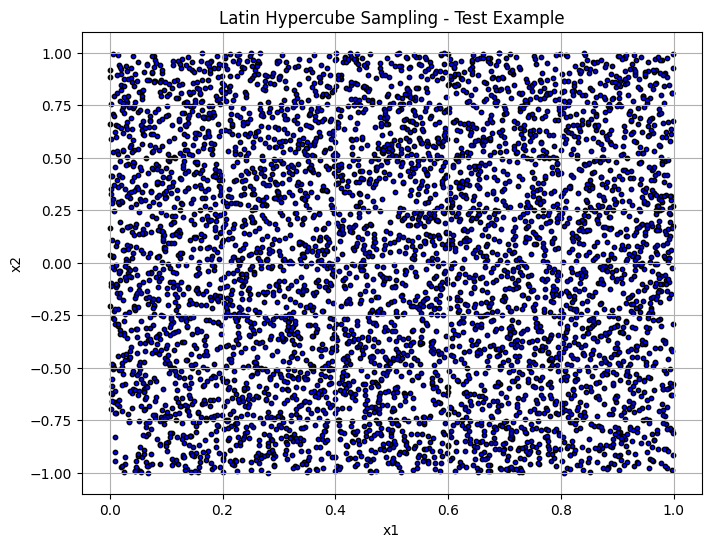

In [5]:
# Now, create a simple test example

# 1. Define variable bounds
bounds = {
    'x1': [0.0, 1.0],   # Variable x1 ranges from 0 to 1
    'x2': [-1.0, 1.0],  # Variable x2 ranges from -1 to 1
}

# 2. Number of samples
NUM_SAMPLES = 5000

# 3. Call the sampling function
samples = lhs_sampling(rand=None, NUM=NUM_SAMPLES, bounds=bounds)

# 4. Display the samples
print(samples.head())

# 5. Plot the samples to visualize the distribution
plt.figure(figsize=(8,6))
plt.scatter(samples['x1'], samples['x2'], c='blue', edgecolors='k', s=10)
plt.title('Latin Hypercube Sampling - Test Example')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

### Sample Generator

We assume $r = q = 0, S_0 = 1$ and create a data set of $\text{NUM}$ observations by randomly sampling from uniform distributions for the other five inputs to the Black-Scholes-Merton formula. The lower and upper bounds of  the uniform distributions are as indicated in the `bounds` dictionary. For each set of  parameters sampled, we calculate the Black-Scholes-Merton price using equations \eqref{eq:bs_call_price} and \eqref{eq:bs_put_price}. 

In [6]:
# For the neural network calculating the vanilla option prices in the Black Scholes model, 
# the features used are the time to maturity T, the moneyness (simply defined as 'Strike') 
# and the asset volatility sigma.
#
# Lower and upper boundaries for each parameter
#
bounds = {  "T"     : [1./12., 2.00]
          , "Sigma" : [ .1  ,  .80]
          , "Strike": [ .4   , 1.20]
         }
#
# Number of Observations
#
NUM = 100000
#
# Random number generator
#
seed = 42
rand = np.random.RandomState()
#
# Latin Hypercube Sampling
#
xDF = lhs_sampling(rand, NUM, bounds=bounds)
xDF.head()

,T,Sigma,Strike
0,1.767882,0.343107,0.955100
1,1.487838,0.784093,1.006932
2,1.084380,0.234817,0.975892
3,0.295250,0.460924,0.860380
4,1.580988,0.230932,1.125452


array([[<Axes: title={'center': 'T'}>, <Axes: title={'center': 'Sigma'}>],
       [<Axes: title={'center': 'Strike'}>, <Axes: >]], dtype=object)

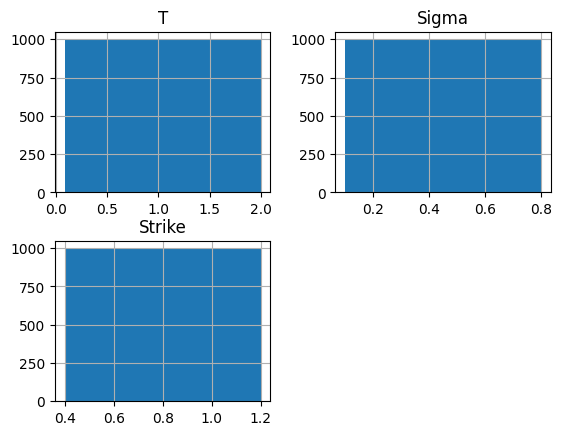

In [7]:
xDF.hist(bins=100)

The for each set of randomly generated parameters, we calculate the theoretical **call** price according to the Black and Scholes model:

In [8]:
def gen(NUM, pars):

    S0     = np.full(NUM, 1.0, dtype = np.double)
    r      = np.full(NUM, 0.0, dtype = np.double)
    price  = np_euro_call(S0, r, pars["T"], pars["Sigma"], pars["Strike"])
    
    df = pd.DataFrame(pars)
    df["Price"] = price

    return df

In [9]:
__tStart = time.perf_counter()
df =  gen(NUM, xDF)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd - __tStart) )

df.head()

(100000,)
@ GEN                               : elapsed 0.0582 sec


,T,Sigma,Strike,Price
0,1.767882,0.343107,0.955100,0.199709
1,1.487838,0.784093,1.006932,0.365313
2,1.084380,0.234817,0.975892,0.108665
3,0.295250,0.460924,0.860380,0.178611
4,1.580988,0.230932,1.125452,0.069888


In [10]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)
print(len(X_train), len(X_test))
X_train.head()

67000 33000


,T,Sigma,Strike,Price
59428,1.701508,0.719763,0.562508,0.547110
34957,0.823425,0.479866,0.652676,0.377323
4264,1.485308,0.272344,0.812732,0.235378
53791,1.320954,0.103126,0.465572,0.534428
82114,0.938310,0.372675,1.082324,0.111498


In [11]:
X_test.head()

,T,Sigma,Strike,Price
75721,0.822160,0.642623,0.694108,0.382496
80184,1.786148,0.239717,0.754404,0.274373
19864,1.256592,0.416754,0.899740,0.229946
76699,0.910423,0.495259,0.777548,0.299653
92991,1.548635,0.591607,0.491076,0.552865


To make the illustration more interesting, we can add a random error to each calculated price. The random error is normally distributed with a mean of zero and a standard deviation of $\epsilon \cdot (P_{max} - P_{min})$ where $\epsilon$ is a scale parameter defined by the user.

In [12]:
def add_noise(rand, Xv, eps):
    X  = Xv.copy()
    xl = np.min(X["Price"])
    xh = np.max(X["Price"])

    xi = rand.normal( loc = 0.0, scale = eps*(xh-xl), size=X.shape[0])
    X["Price"] += xi
    return X

In [13]:
EPS = 0.00
if EPS > 0.0: 
    X_train = add_noise(rand, X_train, EPS)

In [14]:
y_train = X_train['Price']
y_test  = X_test['Price']

Text(0.5, 0, 'BS Price')

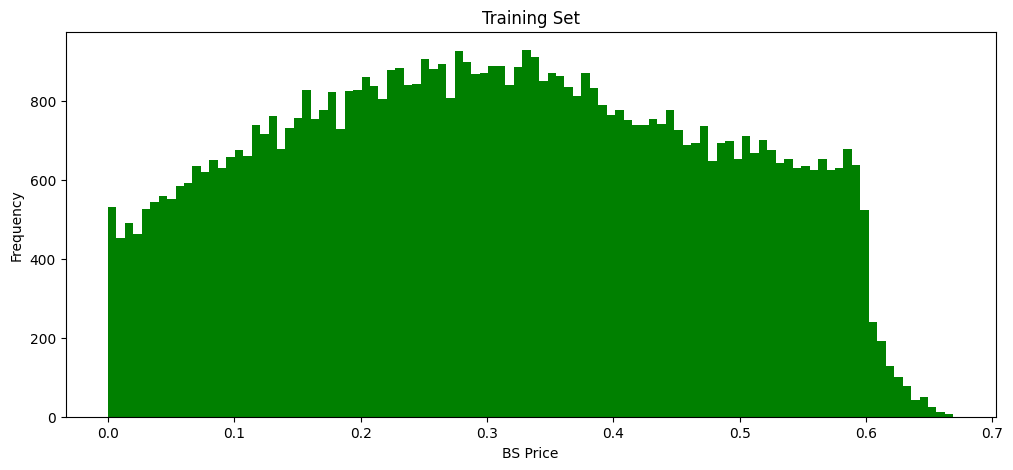

In [15]:
ax=y_train.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='green', title = 'Training Set')
ax.set_xlabel('BS Price')

Text(0.5, 0, 'BS Price')

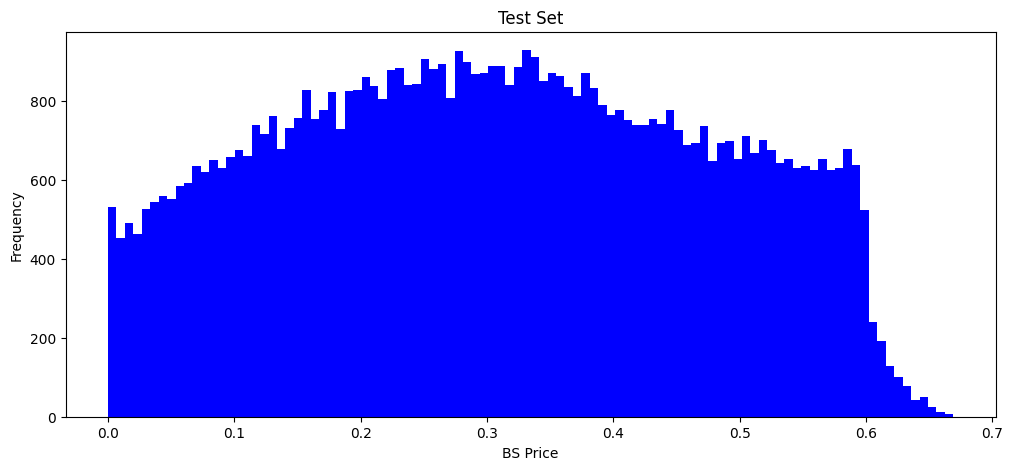

In [16]:
ax=y_train.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='blue', title = 'Test Set')
ax.set_xlabel('BS Price')

In [17]:
X_train = X_train.drop(['Price'], axis=1)
X_test  = X_test.drop(['Price'], axis=1)
X_train.head()

,T,Sigma,Strike
59428,1.701508,0.719763,0.562508
34957,0.823425,0.479866,0.652676
4264,1.485308,0.272344,0.812732
53791,1.320954,0.103126,0.465572
82114,0.938310,0.372675,1.082324


### Scaling Data

In [18]:
from sklearn.preprocessing import StandardScaler

scaling = False

if scaling:
    # Scale the train set
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # Scale the test set
    scaler = StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)
    
    # Transform into pd DataFrame
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

## Create the Model

### Neural Network Architecture

We use mean absolute error (mae) as the cost function. The neural  network has two hidden layers and a decreasing number of neurons per layer. The relu activation function is used. 

In [19]:
from keras.models import Sequential
from keras.layers import Dense

**The input shape**

What flows between layers are tensors. Tensors can be seen as matrices, with shapes. Shapes are consequences of the model's configuration. Shapes are tuples representing how many elements an array or tensor has in each dimension.

> Ex: a shape (30,4,10) means an array or tensor with 3 dimensions, containing 30 elements in the first dimension, 4 in the second and 10 in the third, totaling 30*4*10 = 1200 elements or numbers.

In Keras, the input layer itself is not a layer, but a tensor. It's the starting tensor you send to the first hidden layer. This tensor must have the same shape as your training data. 

> Ex: if you have 30 images of 50x50 pixels in RGB (3 channels), the shape of your input data is (30,50,50,3). Then your  input layer tensor, must have this shape.

Since the input shape is the only one you need to define, Keras will demand it in the first layer. 

In [20]:
def model_builder( inputShape = (1,)):
    # Initialize the constructor
    model = Sequential()
    # Start from the first hidden layer, since the input is not actually a layer   
    # But inform the shape of the input, with inputShape elements.    
    model.add(Dense(200, activation='relu', input_shape=inputShape))
    # Add one more hidden layer 
    model.add(Dense(200, activation='relu'))
    # Add one more hidden layer 
    model.add(Dense(200, activation='relu'))
    # Add an output layer 
    model.add(Dense(1))
    # End model construction

    # Model output shape
    #print("model.output_shape: %s" %(str(model.output_shape)))
    # Model summary
    #print("Model.summary"); model.summary()
    # Model config
    #print("Model.config"); model.get_config()

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [21]:
model = model_builder( inputShape = (X_train.shape[1],))
model.summary()

C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,401 (317.97 KB)

 Trainable params: 81,401 (317.97 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [22]:
def show_scattered( y, t, TAG, ax = None):
    #x      = model.predict(X)
    #y      = np.ravel(x)
    xMin = min(t)
    xMax = max(t)
    v    = np.arange(xMin, xMax, (xMax-xMin)/100.)

    diff   = np.fabs(y - t)
    print("@ %-24s: E[y-t]: %.6f Std(y-t): %.6f" %( TAG, np.mean(diff), np.std(diff)))
    if ax == None: return

    ax.plot( y, t, ".")
    ax.plot( v, v, color="red")
    ax.set_title("%s mae=%8.4f, std=%8.4f" %(TAG, np.mean(diff), np.std(diff)))
    ax.set_xlabel("predicted")
    ax.set_ylabel("target")

In [23]:
def display_nn_results( model, X_train, X_test, t_train, t_test, resFile=None):

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    fig.suptitle("Scattered plots")
    #
    # The numpy module ravel of NumPy provides a function, called numpy.ravel, which is used to change 
    # a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. The returned 
    # array has the same data type as the source array or input array.
    #
    y_train  = np.ravel(model.predict(X_train))
    show_scattered( y_train, t_train, "InSample", ax = ax[0])
    diff   = np.fabs(y_train - t_train)
    delta  = y_train - t_train
    RES    = pd.DataFrame({"predicted": y_train, "target": t_train, "err": diff, "delta": delta})
    h1     = RES['delta'] 
    RES.to_csv("res_in_sample.csv", sep=',', float_format="%.6f", index=True)
    
    y_test  = np.ravel(model.predict(X_test))
    show_scattered( y_test , t_test, "OutOfSample", ax= ax[1])
    diff   = np.fabs(y_test-t_test)
    delta  = y_test - t_test
    RES    = pd.DataFrame({"predicted": y_test, "target": t_test, "err": diff, "delta": delta})
    h2     = RES['delta']
    RES.to_csv("res_ou_sample.csv", sep=',', float_format="%.6f", index=True)

    if resFile != None:
        plt.savefig(resFile, format="png")
        print("\nResults saved to '%s' " % resFile)
    plt.show()


    score = model.evaluate(X_test, t_test, verbose=1)
    print('Score:'); print(score)
    
    h1.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='blue', title = 'err distribution')
    h2.plot(kind='hist', bins=100, grid=False, figsize=(12,5), color='red')


In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(67000, 3)
(33000, 3)
(67000,)
(33000,)


In [25]:
frames = [X_train, X_test]
X = pd.concat(frames)

frames = [y_train, y_test]
Y = pd.concat(frames)

In [26]:
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=25, verbose=1)

Epoch 1/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0042 - mae: 0.0405 - val_loss: 5.7557e-04 - val_mae: 0.0224
Epoch 2/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.4787e-04 - mae: 0.0135 - val_loss: 3.9071e-04 - val_mae: 0.0191
Epoch 3/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.6830e-04 - mae: 0.0111 - val_loss: 2.6051e-04 - val_mae: 0.0153
Epoch 4/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.2878e-04 - mae: 0.0095 - val_loss: 2.3396e-05 - val_mae: 0.0043
Epoch 5/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 1.0800e-04 - mae: 0.0089 - val_loss: 1.6950e-04 - val_mae: 0.0123
Epoch 6/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 9.0159e-05 - mae: 0.0081 - val_loss: 7.2437e-05 - val_mae: 0.0074
Epoch 7/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 7.7554e-05 - mae: 0.0075 - val_loss: 2.2669e-05 - val_mae: 0.0043
Epoch 8/25
2094/2094 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.7724e-05 - mae: 0.0069 - val_loss: 8.7

2094/2094 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
@ InSample                : E[y-t]: 0.001995 Std(y-t): 0.000977
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
@ OutOfSample             : E[y-t]: 0.001993 Std(y-t): 0.000985

Results saved to 'training.png' 


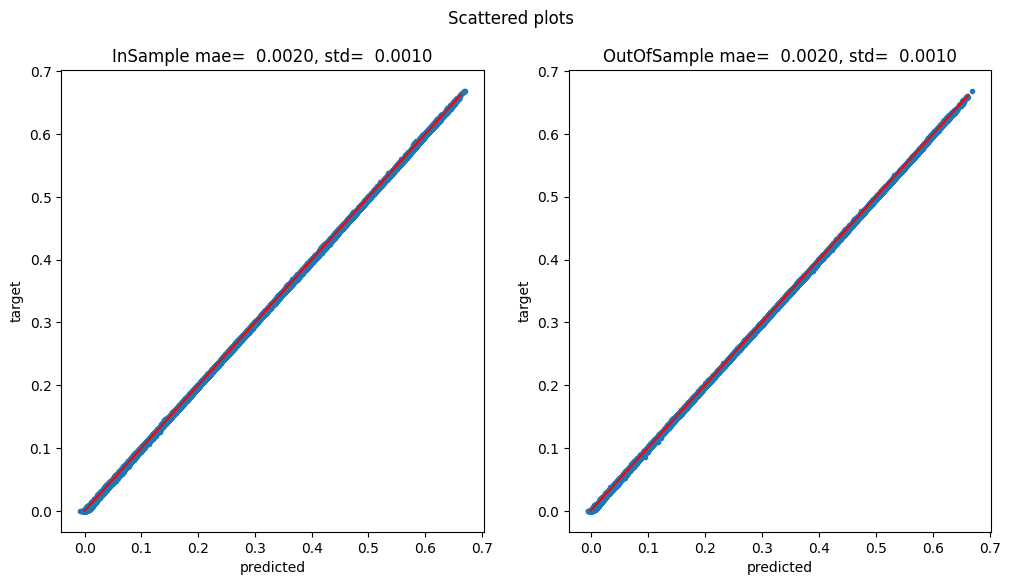

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.9315e-06 - mae: 0.0020
Score:
[4.939904101775028e-06, 0.0019925518427044153]


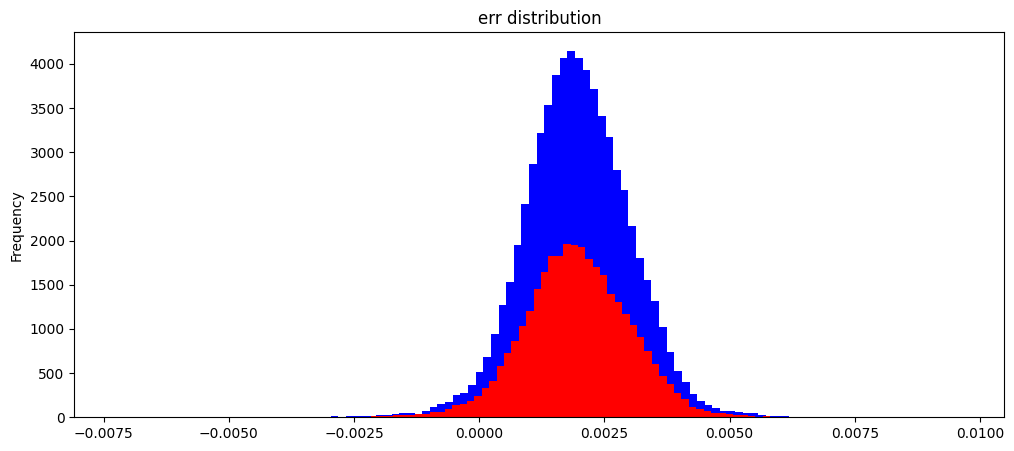

In [27]:
import warnings
warnings.simplefilter('ignore')

display_nn_results(model, X_train, X_test, y_train, y_test, resFile='training.png')

### Access Model Training History in Keras

Keras provides the capability to register callbacks when training a deep learning model. One of the default callbacks that is registered when training all deep learning models is the **History callback**. It records training metrics for each epoch. This includes the loss and the accuracy (for classification problems) as well as the loss and accuracy for the validation dataset, if one is set.

The history object is returned from calls to the fit() function used to train the model. Metrics are stored in a dictionary in the history member of the object returned.

For example, you can list the metrics collected in a history object using the following snippet of code after a model is trained:

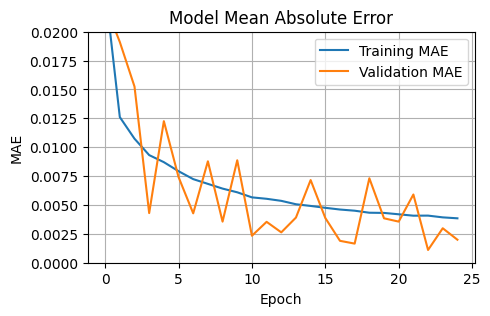

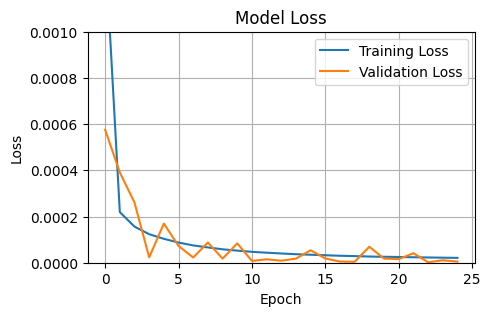

In [28]:
# Set fixed y-axis limits
Y_MIN = 0.0     # Typically zero for loss/MAE
Y_MAX_1 = 0.02    # Example: 2% MAE, you can adapt based on your expected errors
Y_MAX_2 = 0.001

# Plot MAE
plt.figure(figsize=(5,3))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.ylim([Y_MIN, Y_MAX_1])  # <- Fix y-axis
plt.show()

# Plot Loss
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.ylim([Y_MIN, Y_MAX_2])  # <- Fix y-axis
plt.show()


## A Better Approximation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
from scipy.stats import norm

# Improved LHS sampling
def improved_lhs_sampling(NUM):
    """
    Improved parameter generation based on moneyness, volatility, maturity, and rate.

    Returns:
    - DataFrame with sampled parameters
    """
    bounds = {
        'moneyness': [0.9, 1.1],  # S0/K ratio
        'Sigma'    : [0.1, 0.8],  # volatility
        'T'        : [1./12., 2.0],  # time to maturity
        'r'        : [0.0, 0.0], # interest rate
    }
    
    # List of keys
    kw = list(bounds)
    
    # Build limits array
    limits = np.array([bounds[k] for k in kw])
    
    # LHS sampling
    sampling = LHS(xlimits=limits)
    x = sampling(NUM)

    # Create DataFrame
    X = pd.DataFrame()
    for n in range(len(kw)):
        tag = kw[n]
        X[tag] = x[:, n]

    return X

# Simple Black-Scholes call price function (assuming K=1)
def bs_call_price(S0, K, r, sigma, tau):
    if sigma * np.sqrt(tau) < 1e-10:
        return max(S0 - K * np.exp(-r * tau), 0.0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

# Now, generate samples
NUM_SAMPLES = 100000
samples = improved_lhs_sampling(NUM_SAMPLES)

# Assume S0 = 1 for simplicity
samples['K'] = 1.0 / samples['moneyness']

# Compute Black-Scholes call prices
samples['Price'] = samples.apply(lambda row: bs_call_price(1.0, row['K'], row['r'], row['Sigma'], row['T']), axis=1)

# Plot the histogram of generated call prices
plt.figure(figsize=(10, 5))
plt.hist(samples['Price'], bins=100, color='blue', edgecolor='k')
plt.title('Training Set (Improved Parameter Generation)')
plt.xlabel('BS Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
samples.head()

In [ ]:
X_train_2, X_test_2 = train_test_split(samples, test_size=0.33, random_state=42)
print(len(X_train_2), len(X_test_2))
X_train_2.head()

In [ ]:
y_train_2 = X_train_2['Price']
y_test_2  = X_test_2['Price']

In [ ]:
X_train_2 = X_train_2.drop(['Price', 'moneyness', 'r'], axis=1)
X_test_2  = X_test_2.drop(['Price', 'moneyness', 'r'], axis=1)
X_train_2.head()

In [ ]:
print(X_train_2.shape)
print(X_test_2.shape)
print(y_train_2.shape)
print(y_test_2.shape)

In [ ]:
frames = [X_train_2, X_test_2]
X_2 = pd.concat(frames)

frames = [y_train_2, y_test_2]
Y_2= pd.concat(frames)

In [ ]:
# Fit the model
history = model.fit(X_2, Y_2, validation_split=0.33, epochs=25, verbose=0)

In [ ]:
import warnings
warnings.simplefilter('ignore')

display_nn_results(model, X_train_2, X_test_2, y_train_2, y_test_2, resFile='training_2.png')

In [ ]:
# Set fixed y-axis limits
Y_MIN = 0.0     # Typically zero for loss/MAE
Y_MAX_1 = 0.02    # Example: 2% MAE, you can adapt based on your expected errors
Y_MAX_2 = 0.001

# Plot MAE
plt.figure(figsize=(5,3))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.ylim([Y_MIN, Y_MAX_1])  # <- Fix y-axis
plt.show()

# Plot Loss
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.ylim([Y_MIN, Y_MAX_2])  # <- Fix y-axis
plt.show()


## Saving the Model

In [ ]:
TAG        = 'bs-0100000-050-T'
mdlDir     = "model_%s.keras" %(TAG)


model.save(mdlDir)
print("@ %-24s: model saved to '%s'" %("Info", mdlDir))  

## Appendix

### Why is $ M_T $ a martingale?

$ M_T $ is defined as:

$$
M_T := \frac{e^{-r(T-t)} S_T}{S_t}
$$

Now we check if $ (M_u)_{u \geq t} $ is a martingale under the risk-neutral measure $ \mathbb{Q} $.

**Recall**:

Under $ \mathbb{Q} $, the discounted stock price $ (e^{-r(u-t)} S_u) $ is a martingale.

That is:

$$
\mathbb{E}^\mathbb{Q} \left[ e^{-r(u'-t)} S_{u'} \, \big| \, \mathcal{F}_u \right] = e^{-r(u-t)} S_u
\quad \text{for all} \quad t \leq u \leq u'
$$

Thus, if we define:

$$
M_u := \frac{e^{-r(u-t)} S_u}{S_t}
$$

then:

$$
\mathbb{E}^\mathbb{Q} \left[ M_{u'} \, \big| \, \mathcal{F}_u \right]
= \mathbb{E}^\mathbb{Q} \left[ \frac{e^{-r(u'-t)} S_{u'}}{S_t} \, \bigg| \, \mathcal{F}_u \right]
= \frac{1}{S_t} \mathbb{E}^\mathbb{Q} \left[ e^{-r(u'-t)} S_{u'} \, \big| \, \mathcal{F}_u \right]
$$

but since $ e^{-r(u'-t)} S_{u'} $ is a martingale:

$$
= \frac{1}{S_t} e^{-r(u-t)} S_u
= e^{-r(u-t)} \frac{S_u}{S_t}
= M_u
$$

Thus:
$$
\mathbb{E}^\mathbb{Q}[M_{u'}|\mathcal{F}_u] = M_u
$$

meaning $ (M_u)_{u \geq t} $ is a **martingale**.

### Why do we say “martingale with zero interest rate”?


Under the **risk-neutral measure** $ \mathbb{Q} $, it is a **basic fact** from financial theory that:

$$
\left( e^{-r(u-t)} S_u \right)_{u \geq t} \quad \text{is a martingale}.
$$

**Why?**

Because under $ \mathbb{Q} $, $ S_u $ follows:

$$
dS_u = r S_u \, du + \sigma S_u \, dW_u^\mathbb{Q}
$$

and the process $ e^{-r(u-t)} S_u $ has exactly the drift term that cancels the risk-free rate $ r $.

When you compute $ d(e^{-r(u-t)} S_u) $ using Itô's lemma, you get:

$$
d(e^{-r(u-t)} S_u) = e^{-r(u-t)} \sigma S_u \, dW_u^\mathbb{Q}
$$

**no drift term** → it's a local martingale → and under mild conditions on $ S_u $, it's a true martingale.

Thus:

$$
\mathbb{E}^\mathbb{Q}\left[ e^{-r(u'-t)} S_{u'} \,|\, \mathcal{F}_u \right] = e^{-r(u-t)} S_u
\quad \text{for all} \quad t \leq u \leq u'
$$

Now, $ M_u $ is just $ e^{-r(u-t)} S_u $ normalized by $ S_t $

We have:

$$
M_u = \frac{e^{-r(u-t)} S_u}{S_t}
$$

Since $ S_t $ is **known** at time $ t $ (deterministic from the viewpoint of $ t $), dividing by $ S_t $ is just scaling by a constant.

Thus, if $ e^{-r(u-t)} S_u $ is a martingale, **then $ M_u $ is a martingale too** (because multiplying/dividing by a constant preserves the martingale property).

$ M_u $ behaves like the **price process** of an asset that:

- starts at $ M_t = 1 $,
- has **no drift**,
- only has volatility $ \sigma $,
- evolves according to a pure geometric Brownian motion **without any risk-free rate adjustment**.

Meaning: it’s as if the underlying asset $ M_u $ evolves in a market where $ r = 0 $.

Specifically, $ M_u $ satisfies a **pure diffusion** SDE:

$$
dM_u = \sigma M_u \, dW_u^\mathbb{Q}
$$

(no $ r $ term, no drift, only randomness from $ dW_u^\mathbb{Q} $).

In that world:

- The discounted price is the same as the non-discounted price (because $ r=0 $),
- You don’t need to adjust cash flows by $ e^{-r(T-t)} $.

Thus, **$ M_u $ is a martingale in a world where the interest rate is 0**.